In [1]:
import numpy as np
import altair as alt
import pandas as pd

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

## Practice the Probabilistic Codes on arXiv:1804.06458

I found this paper is quite interesting [Deep Probabilistic Programming Languages: A Qualitative Study](https://arxiv.org/abs/1804.06458). Since it provides some codes in the paper, I would like to reproduce them. There are three PPL in this Paper: 

- `PyStan`
- `Pyro`
- `Edward`

The other package that I frequently used but not listed in the paper is `PyMC3`. It would be a good practice to start.

## Stan

BTW: I found [VS Code](https://code.visualstudio.com) has an [extension](https://marketplace.visualstudio.com/items?itemName=ivan-bocharov.stan-vscode) for syntax highlight of `.stan`. 

In [2]:
# This Code is modified from the Figure2 (a) of the paper

import pystan

# Coin Model
coin_code = """
data {
    int<lower=0, upper=1> x[10]; // integer array with 10 elements
}

parameters {
    real <lower=0, upper=1> theta;
}

model {
    theta ~ uniform(0, 1);
    for (i in 1:10)
        x[i] ~ bernoulli(theta);
}
"""

# Data
data = {'x' : [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]}

# Inference
sm = pystan.StanModel(model_code=coin_code)
fit = sm.sampling(data=data, iter=1000, )

# Results
stan_samples = fit.extract()['theta']
print("Posterior mean:", np.mean(stan_samples))
print("Posterior stddev:", np.std(stan_samples))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae4b69f2c32ace4a5a44bd7fe8bd8619 NOW.


Posterior mean: 0.25023429786418494
Posterior stddev: 0.11834472207875706


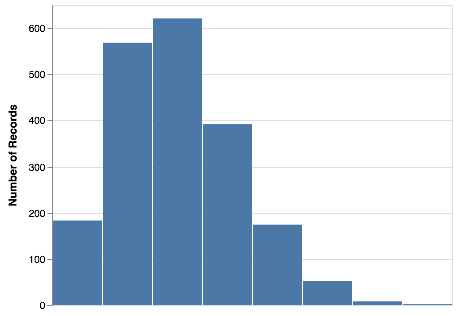

In [3]:
# Posterior samples
stan_data = pd.DataFrame({
    'theta' : stan_samples
})

alt.Chart(stan_data).mark_bar().encode(
    alt.X('theta', bin=True, axis=None),
    alt.Y('count()')
)

## Edward

In [4]:
# this code is modified from Figure 2 (b) in the paper
import edward as ed
from edward.models import Uniform, Bernoulli, Empirical
import tensorflow as tf

# Model
theta = Uniform(0.0, 1.0) # sample the from prior dist
x = Bernoulli(probs=theta, sample_shape=10) # sample vector of RVs from Bernoulli dist

# Data
data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1]) 

# Inference
qtheta = Empirical(
    tf.Variable(tf.ones(1000) * 0.5) # placeholder, depends on inference procedure
)

# Hamiltonian Monte Carlo
inference = ed.HMC(
    {theta : qtheta},  # prior : posterior
    data={x : data})
inference.run()

# mean and std
mean, stddev = ed.get_session().run([
    qtheta.mean(), qtheta.stddev()
])
print("Posterior mean:", mean)
print("Posterior stddev:", stddev)

/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/edward/util/random_variables.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/edward/util/random_variables.py:49: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Acceptance Rate: 0.326
Posterior mean: 0.23616
Posterior stddev: 0.119168624


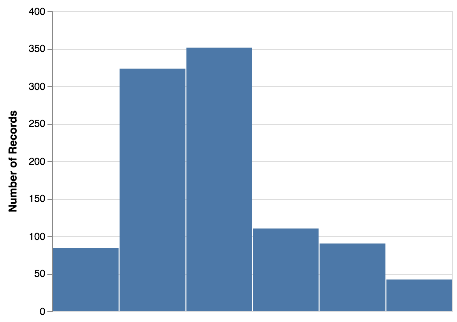

In [5]:
# sampling
ed_samples = ed.get_session().run(
    [qtheta.sample(sample_shape=(1000, ))]
)[0]

# Posterior samples
ed_data = pd.DataFrame({
    'theta' : ed_samples
})

alt.Chart(ed_data).mark_bar().encode(
    alt.X('theta', bin=True, axis=None),
    alt.Y('count()')
)

## Pyro

In [6]:
import pyro
from pyro.distributions import Bernoulli, Uniform
from torch.autograd import Variable
import torch

# Model, define model as a function coin
def coin(data):
    theta = pyro.sample("theta", Uniform( # sample theta from prior
        Variable( torch.Tensor([0]) ),
        Variable( torch.Tensor([1]) )
    ))
    pyro.sample("x", Bernoulli( # sample a RV vector from Bernoulli
        theta * Variable( torch.ones(10) ),),
        obs=data["x"]
       )
    
# Data, as a dict
data = {"x" : Variable(torch.Tensor([
    0, 1, 0, 0, 0, 0, 0, 0, 0, 1
]))}

## NOTE: I add some modifications here, since some functions are
## removed from newer version of pyro
# Inference
posterior = pyro.infer.Importance(coin, num_samples=1000)

# pyro.infer.Marginal has been removed: https://github.com/uber/pyro/pull/1019
marginal = pyro.infer.EmpiricalMarginal(posterior.run(data), sites="theta")

# Results
pyro_samples = [marginal().item() for _ in range(1000)]
print("Posterior mean:", np.mean(pyro_samples))
print("Posterior stddev:", np.std(pyro_samples))

Posterior mean: 0.2587190387845039
Posterior stddev: 0.11984534389502184


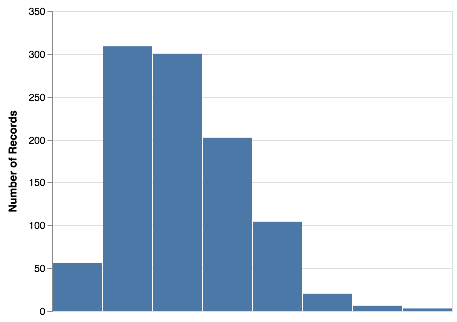

In [7]:
# Posterior samples
pyro_data = pd.DataFrame({
    'theta' : pyro_samples
})

alt.Chart(pyro_data).mark_bar().encode(
    alt.X('theta', bin=True, axis=None),
    alt.Y('count()')
)

## PyMC3

In [12]:
import pymc3 as pm

data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1]) 

with pm.Model() as model:
    theta = pm.Uniform("theta", lower=0, upper=1)
    x = pm.Bernoulli("x", theta, observed=data)
    pm_samples = pm.sample(draws=1000)
    
print("Posterior mean:", pm_samples['theta'].mean())    
print("Posterior stddev:", pm_samples['theta'].std())    

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [theta_interval__]
100%|██████████| 1500/1500 [00:00<00:00, 2134.61it/s]


Posterior mean: 0.2507592072740713
Posterior stddev: 0.1212173742748953


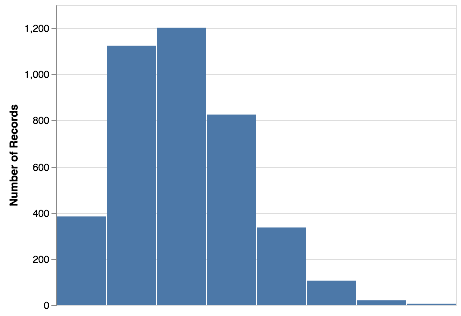

In [13]:
# Posterior samples
pm_data = pd.DataFrame({
    'theta' : pm_samples["theta"]
})

alt.Chart(pm_data).mark_bar().encode(
    alt.X('theta', bin=True, axis=None),
    alt.Y('count()')
)

## Charts

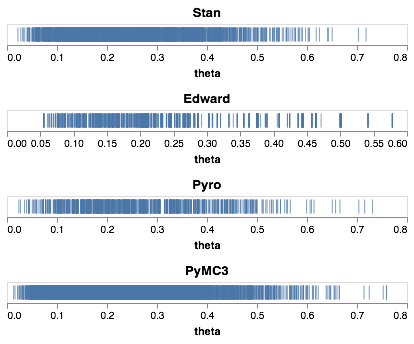

In [14]:
stan_chart = alt.Chart(stan_data, title="Stan").mark_tick().encode(
    alt.X('theta', ),
)
ed_chart = alt.Chart(ed_data, title="Edward").mark_tick().encode(
    alt.X('theta', ),
)
pyro_chart = alt.Chart(pyro_data, title="Pyro").mark_tick().encode(
    alt.X('theta', ),
)
pm_chart = alt.Chart(pm_data, title="PyMC3").mark_tick().encode(
    alt.X('theta', ),
)

stan_chart & ed_chart & pyro_chart &  pm_chart 

Well... note sure what happens. It seems stan is much more like pymc3, and pyro and edward have similar dists.